# **ESRGAN with TF-GAN on GPU**

### **Overview**
This notebook demonstrates the E2E process of data loading, preprocessing, training and evaluation of the [ESRGAN](https://arxiv.org/abs/1809.00219) model using Tensorflow and TF-GAN. To understand the basics of TF-GAN and explore more features of the library, please visit [TF-GAN tutorial](https://github.com/tensorflow/gan/blob/master/tensorflow_gan/examples/colab_notebooks/tfgan_tutorial.ipynb) notebook first. 

For training the ESRGAN model on Colab GPU, certain parameters such as batch size and HR Image dimension has been reduced compared to the official paper implementation. The end-to-end training process can also take 3+ hours which exceeds the maximum idle runtime on the free version of Colab, but can be completed without issues on Colab Pro. 

Please visit the [ESRGAN with TF-GAN on TPU](https://colab.research.google.com/github/tensorflow/gan/tree/master/tensorflow_gan/examples/esrgan/colab_notebooks/ESRGAN_TPU.ipynb) notebook that makes use of Colab TPU for faster training and follows the same parameters as the official implementation. 
### **Steps to run this notebook**


* Click on the icon to open this notebook in Google Colaboratory. 

> [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorflow/gan/tree/master/tensorflow_gan/examples/esrgan/colab_notebooks/ESRGAN_GPU.ipynb)

*  Navigate to `Runtime > Change runtime type` tab 
* Select GPU from hardware accelerator and save
* Click Connect in the upper right corner and select Connect to hosted runtime.

In [ ]:
# Check that imports for the rest of the file work.
import os
import tensorflow as tf
!pip install tensorflow-gan
import tensorflow_gan as tfgan
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
import PIL 
from tensorflow.python.data.experimental import AUTOTUNE

### **Learning Objectives**
Through this Colab notebook you will learn how to :
* Implement the ESRGAN model and train it
* Make use of various TF-GAN functions to visualize and evaluate the results. 

### **Training ESRGAN**
The ESRGAN model proposed in the paper [ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks (Wang Xintao et al.)](https://arxiv.org/abs/1809.00219) performs the task of image super-resolution which is the process of reconstructing high resolution (HR) image from a given low resolution (LR) image.  Such a task has numerous application in today's world. The [Super-Resolution GAN](https://arxiv.org/abs/1609.04802) model was a major breathrough in this field and was capable of generating photorealistic images, however the model also generated artifacts that reduced the overall visual quality. To overcome this, the ESRGAN model was proposed with three major changes made to the SRGAN model : 
1. Using Residual-in-Residual Dense Block (RRDB) without batch normalization as basic network building unit 
2. Using an improved method to calculate adversarial loss used in [RelativisticGAN](https://arxiv.org/abs/1807.00734v3)
3. Improving perceptual loss function by using features before activation. 

Go to the [**visualize results**](https://colab.research.google.com/drive/1Q4PCi1V0rwo1YwacKEjPZxXXIuZPRZO1#scrollTo=6IosyrMs_av4&line=2&uniqifier=1) cell to see some of the results obtained.

## Define Parameters

Add paths to save the models and dataset. Certain parameters such as batch size and dimension of HR Images needs to be reduced while training on Colab GPU.


In [2]:
Params = {
  'batch_size' : 8,                   # Number of image samples used in each training step          
  'hr_dimension' : 128,               # Dimension of a High Resolution (HR) Image
  'scale' : 4,                        # Factor by which Low Resolution (LR) Images will be downscaled.
  'data_name': 'div2k/bicubic_x4',    # Dataset name - loaded using tfds.
  'trunk_size' : 11,                  # Number of Residual blocks used in Generator,
  'init_lr' : 0.00005,                # Initial Learning rate for networks. 
  'ph1_steps' : 10000,                # Number of steps required for phase-1 training
  'ph2_steps' : 100000,               # Number of steps required for phase-2 training
  'decay_ph1' : 0.2,                  # Factor by which learning rates are modified during phase-1 training 
  'decay_ph2' : 0.5,                  # Factor by which learning rates are modified during phase-2 training 
  'model_dir' : '/content/',          # Path to save the model after training. (inside the cloud bucket)
  'ckpt_dir' : '/content/ckpts/',     # Path to save the training checkpoints. (outside the cloud bucket)
  'lambda' : 0.005,                   # To balance adversarial loss during phase-2 training. 
  'eta' : 0.01,                       # To balance L1 loss during phase-2 training.
  'val_steps' : 100                   # Number of steps required for validation.
}

## Load Training Dataset
We have used the [DIV2K](https://data.vision.ee.ethz.ch/cvl/DIV2K/) dataset which is usually used for benchmarking super resolution models. DIV2K dataset provides various kinds of image from which we are downloading only the HR images and corresponding LR images downsampled using bicubic downsampling. All the HR images are also scaled to 128 x 128 and LR images to 32 x 32.    

In [3]:
def input_fn(mode, params):
  assert 'batch_size' in params
  bs = params['batch_size']
  split = 'train' if mode == 'train' else 'validation'
  shuffle = True 

  def scale(image, *args):
    hr_size = params['hr_dimension']
    scale = params['scale']

    hr_image = image
    hr_image = tf.image.resize(hr_image, [hr_size, hr_size])
    lr_image = tf.image.resize(hr_image, [hr_size//scale, hr_size//scale], method='bicubic')
    
    hr_image = tf.clip_by_value(hr_image, 0, 255)
    lr_image = tf.clip_by_value(lr_image, 0, 255)
    
    return lr_image, hr_image

  dataset = (tfds.load(params['data_name'], split=split, as_supervised=True)
             .map(scale, num_parallel_calls=4)
             .cache()
             .repeat())
  if shuffle:
    dataset = dataset.shuffle(
        buffer_size=10000, reshuffle_each_iteration=True)
  dataset = (dataset.batch(bs, drop_remainder=True)
               .prefetch(tf.data.experimental.AUTOTUNE))
  
  return iter(dataset)

In [ ]:
train_ds = input_fn(mode='train', params=Params)

## Visualize the dataset

In [ ]:
img_lr, img_hr = next(iter(train_ds))
lr = PIL.Image.fromarray(np.array(img_lr)[0].astype(np.uint8))
lr = lr.resize([256, 256])
display(lr)

hr = PIL.Image.fromarray(np.array(img_hr)[0].astype(np.uint8))
hr = hr.resize([256, 256])
display(hr)

## Network Architecture
The basic network buidling unit of the  ESRGAN is the Residual-in-Residual Block (RRDB) without batch normalization. The network implemented is similar to the architecture proposed in the paper.



### Generator Network

In [6]:
def _conv_block(input, filters, activation=True):
  h = layers.Conv2D(filters, kernel_size=[3,3], 
                    kernel_initializer="he_normal", bias_initializer="zeros", 
                    strides=[1,1], padding='same', use_bias=True)(input)
  if activation:
      h = layers.LeakyReLU(0.2)(h)
  return h

def dense_block(input):
  h1 = _conv_block(input, 32)
  h1 = layers.Concatenate()([input, h1])

  h2 = _conv_block(h1, 32)
  h2 = layers.Concatenate()([input, h1, h2])

  h3 = _conv_block(h2, 32)
  h3 = layers.Concatenate()([input, h1, h2, h3])

  h4 = _conv_block(h3, 32)
  h4 = layers.Concatenate()([input, h1, h2, h3, h4])  

  h5 = _conv_block(h4, 32, activation=False)
  
  h5 = layers.Lambda(lambda x: x * 0.2)(h5)
  h = layers.Add()([h5, input])
  
  return h

def rrdb(input):
  h = dense_block(input)
  h = dense_block(h)
  h = dense_block(h)
  h = layers.Lambda(lambda x:x * 0.2)(h)
  out = layers.Add()([h, input])
  return out

def upsample(x, filters):
  x = layers.Conv2DTranspose(filters, kernel_size=3, 
                             strides=2, padding='same', 
                             use_bias = True)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  return x

def generator_network(filter=32, 
                      trunk_size=Params['trunk_size'], 
                      out_channels=3):
  lr_input = layers.Input(shape=(None, None, 3))
    
  x = layers.Conv2D(filter, kernel_size=[3,3], strides=[1,1], 
                    padding='same', use_bias=True)(lr_input)
  x = layers.LeakyReLU(0.2)(x)
  
  ref = x
  for i in range(trunk_size):
      x = rrdb(x)

  x = layers.Conv2D(filter, kernel_size=[3,3], strides=[1,1], 
                    padding='same', use_bias = True)(x)
  x = layers.Add()([x, ref])

  x = upsample(x, filter)
  x = upsample(x, filter)
  
  x = layers.Conv2D(filter, kernel_size=3, strides=1, 
                    padding='same', use_bias=True)(x)
  x = layers.LeakyReLU(0.2)(x)
  hr_output = layers.Conv2D(out_channels, kernel_size=3, strides=1, 
                            padding='same', use_bias=True)(x)

  model = tf.keras.models.Model(inputs=lr_input, outputs=hr_output)
  return model

### Discriminator Network
 

In [7]:
def _conv_block_d(x, out_channel):
  x = layers.Conv2D(out_channel, 3,1, padding='same', use_bias=False)(x)
  x = layers.BatchNormalization(momentum=0.8)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)

  x = layers.Conv2D(out_channel, 4,2, padding='same', use_bias=False)(x)
  x = layers.BatchNormalization(momentum=0.8)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  return x

def discriminator_network(filters = 64, training=True):
  img = layers.Input(shape = (Params['hr_dimension'], Params['hr_dimension'], 3))
  
  x = layers.Conv2D(filters, [3,3], 1, padding='same', use_bias=False)(img)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.2)(x)

  x = layers.Conv2D(filters, [3,3], 2, padding='same', use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.2)(x)

  x = _conv_block_d(x, filters *2)
  x = _conv_block_d(x, filters *4)
  x = _conv_block_d(x, filters *8)
  
  x = layers.Flatten()(x)
  x = layers.Dense(100)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Dense(1)(x)

  model = tf.keras.models.Model(inputs = img, outputs = x)
  return model

## Loss Functions
The ESRGAN model makes use of three loss functions - pixel loss, perceptual loss (vgg_loss) and adversarial loss. Perceptual loss is calculated using the pre-trained VGG-19 network. Adversarial loss is separately calculated for both generator (relativistic_avg_loss_g) and discriminator (relativistic_avg_loss_d) using relativistic discriminator discussed in the paper. 

These loss functions ensures the balance between visual quality and metrics such as PSNR and encorages the generator to produce more realistic images with natural textures.  

In [8]:
def pixel_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.reduce_mean(tf.reduce_mean(tf.abs(y_true - y_pred), axis = 0))

# Functions for calculating adversarial loss. 
def ragan_discriminator_loss(d_real, d_fake):
  def get_logits(x, y):
    return x - tf.reduce_mean(y)
  
  real_logits = get_logits(d_real, d_fake)
  fake_logits = get_logits(d_fake, d_real)

  real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
          labels=tf.ones_like(real_logits), logits=real_logits))
  fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
      labels=tf.zeros_like(fake_logits), logits=fake_logits))

  return real_loss + fake_loss

def ragan_generator_loss(d_real, d_fake):
  real_logits = d_real - tf.reduce_mean(d_fake)
  fake_logits = d_fake - tf.reduce_mean(d_real)
  
  real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
      labels=tf.zeros_like(real_logits), logits=real_logits))  
  fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
      labels=tf.ones_like(fake_logits), logits=fake_logits))

  return real_loss + fake_loss
  
# Function for calculating perceptual loss
def vgg_loss(weight=None, input_shape=None):
  vgg_model = tf.keras.applications.vgg19.VGG19(
      input_shape=input_shape, weights=weight, include_top=False
  )

  for layer in vgg_model.layers:
    layer.trainable = False

  vgg_model.get_layer("block5_conv4").activation = lambda x: x
  vgg = tf.keras.Model(
      inputs=[vgg_model.input],
      outputs=[vgg_model.get_layer("block5_conv4").output])

  def loss(y_true, y_pred):
      return tf.compat.v1.losses.absolute_difference(vgg(y_true), vgg(y_pred))

  return loss

## Training
ESRGAN model is trained in two phases in which the first phase deals with training the generator network individually and is aimed at improving the PSNR values of generated images by reducing the L1 loss.  

Training of the same generator model is continued in the second phase along with the discriminator network. In the second phase, the generator reduces the L1 Loss, Relativistic average GAN (RaGAN) loss which indicates how realistic does the generated image look and the imporved Perceptual loss proposed in the paper.  


In [9]:
# To display images in the order : LR Image -> Generated Image -> HR Image
def visualize_results(image_lr, generated, image_hr):
  size = 128
  resized_lr = tf.image.resize(image_lr, [size, size], method=tf.image.ResizeMethod.BILINEAR)
  resized_gen = tf.image.resize(generated, [size, size], method=tf.image.ResizeMethod.BILINEAR)
  resized_hr = tf.image.resize(image_hr, [size, size], method=tf.image.ResizeMethod.BILINEAR)

  stack = tf.stack([resized_lr[0], resized_gen[0], resized_hr[0]])

  image_grid = tfgan.eval.python_image_grid(stack, grid_shape=(1, 3))
  result = PIL.Image.fromarray(image_grid.astype(np.uint8))
  return result

### Phase - 1 Training

Steps Involved:

* Define the generator and its optimizer. 
* Take LR, HR image pairs from the training dataset
* Input the LR image to the generator network
* Calculate the L1 loss using the generated image and HR image
* Calculate gradient value and apply it to the optimizer
* Update the learning rate of optimizer after every decay steps for better performance

In [10]:
metric = tf.keras.metrics.Mean()
psnr_metric = tf.keras.metrics.Mean()

generator = generator_network()

g_optimizer = tf.optimizers.Adam(
    learning_rate = 0.0002,
    beta_1 = 0.9,
    beta_2 = 0.99
)

In [11]:
def train_step(image_lr, image_hr):
  with tf.GradientTape() as tape:
    fake = generator(image_lr)
    loss = pixel_loss(image_hr, fake) * (1.0 / Params['batch_size'])
    psnr_value = tf.image.psnr(fake, image_hr,max_val = 256.0)
 
    metric(loss)

    gradient = tape.gradient(loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(gradient, generator.trainable_variables))

    return psnr_value

def val_steps(image_lr, image_hr):
  fake = generator(image_lr)
  result = visualize_results(image_lr, fake, image_hr)
  display(result)

In [ ]:
step_count = 0

while step_count < Params['ph1_steps']:
  lr, hr = next(train_ds)
  psnr_value = train_step(lr, hr)
  psnr_metric(psnr_value)
  
  if step_count%1000 == 0:
    print("step {}      PNSR = {}".format(step_count, psnr_metric.result()))
    val_steps(lr, hr) 
  
  step_count+=1

  if step_count%5000 == 0:
    g_optimizer.learning_rate.assign(
        g_optimizer.learning_rate * Params['decay_ph1'])  

In [ ]:
# Save the generator network which is then used for phase-2 training
os.makedirs(Params['model_dir'] + '/Phase_1/generator', exist_ok = True)
generator.save(Params['model_dir'] + '/Phase_1/generator')


###**Phase - 2**

#### Define optimizers and load networks
 * Generator network trained in Phase 1 is loaded.
 * Checkpoints are also defined which can be useful during training. 

In [13]:
optimizer = tf.optimizers.Adam(
    learning_rate = 0.0002,
    beta_1 = 0.9,
    beta_2 = 0.99
)

generator = tf.keras.models.load_model(Params['model_dir'] + 'Phase_1/generator')
discriminator = discriminator_network()

g_optimizer = optimizer
g_optimizer.learning_rate.assign(0.00005)
d_optimizer = optimizer

checkpoint = tf.train.Checkpoint(G=generator,
                                 D = discriminator,
                                 G_optimizer=g_optimizer,
                                 D_optimizer=d_optimizer)

In [ ]:
perceptual_loss = vgg_loss(
        weight = "imagenet",
        input_shape = [Params['hr_dimension'], Params['hr_dimension'], 3])

In [15]:
gen_metric = tf.keras.metrics.Mean()
disc_metric = tf.keras.metrics.Mean()
psnr_metric = tf.keras.metrics.Mean()

In [16]:
def train_step(image_lr, image_hr):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    fake = generator(image_lr)

     percep_loss = tf.reduce_mean(perceptual_loss(image_hr, fake)) 
     l1_loss = pixel_loss(image_hr, fake) 
     
     real_logits = discriminator(image_hr) 
     fake_logits = discriminator(fake) 
     loss_RaG = ragan_generator_loss(real_logits, fake_logits) 
     disc_loss = ragan_discriminator_loss(real_logits, fake_logits) 

     gen_loss = percep_loss + Params['lambda'] * loss_RaG + Params['eta'] * l1_loss

     gen_loss = gen_loss * (1.0 / Params['batch_size'])
     disc_loss = disc_loss * (1.0 / Params['batch_size'])
     psnr_loss = tf.image.psnr(fake, image_hr, max_val = 256.0)
     
     disc_metric(disc_loss) 
     gen_metric(gen_loss)
     psnr_metric(psnr_loss)
     
     disc_grad = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
     d_optimizer.apply_gradients(zip(disc_grad, discriminator.trainable_variables))

     gen_grad = gen_tape.gradient(gen_loss, generator.trainable_variables) 
     g_optimizer.apply_gradients(zip(gen_grad, generator.trainable_variables))
     
     return [disc_loss, gen_loss, psnr_loss]

def val_steps(image_lr, image_hr):
  fake = generator(image_lr)
  result = visualize_results(image_lr, fake, image_hr)
  display(result)

In [ ]:
step_count = 0
decay_step = [9000, 30000, 80000, 100000]

while step_count < Params['ph2_steps']:  
  lr, hr = next(train_ds)
  
  if tf.train.latest_checkpoint(Params['ckpt_dir']): 
    checkpoint.restore(tf.train.latest_checkpoint(Params['ckpt_dir']))

  disc_loss, gen_loss, psnr_loss = train_step(lr, hr)

  if step_count % 1000 == 0:
    print("step {}".format(step_count) + "   Generator Loss = {}   ".format(gen_metric.result()) + 
          "Disc Loss = {}".format(disc_metric.result()) + "   PSNR : {}".format(psnr_metric.result()))
    val_steps(lr, hr)
  
  checkpoint.write(Params['ckpt_dir'])
  
  if step_count >= decay_step[0]:
    decay_step.pop(0)
    
    g_optimizer.learning_rate.assign(
              g_optimizer.learning_rate * Params['decay_ph2'])
    d_optimizer.learning_rate.assign(
        d_optimizer.learning_rate * Params['decay_ph2'])
  
  step_count += 1

In [ ]:
generator.save(Params['model_dir'] + 'Phase_2/generator/')
discriminator.save(Params['model_dir'] + 'Phase_2/discriminator/')

###**Network Interpolation**
Network Interpolation as explained in the paper is used to balance the effect of the generator trained during phase 1 and phase 2. 

In [ ]:
def network_interpolation(alpha=0.2,
                          phase_1_path=None,
                          phase_2_path=None):
  psnr_gen = tf.keras.models.load_model(phase_1_path)
  gan_gen = tf.keras.models.load_model(phase_2_path)

  for var_1, var_2 in zip(gan_gen.trainable_variables, 
                          psnr_gen.trainable_variables):
    var_1.assign((1 - alpha) * var_2 + alpha * var_1)

  return gan_gen

In [ ]:
generator = network_interpolation(phase_1_path = Params['model_dir'] + '/Phase_1/generator',
                                  phase_2_path = Params['model_dir'] + '/Phase_2/generator')
generator.save(Params['model_dir'] + '/InterpolatedGenerator/')

## Evaluation


In [ ]:
val_ds = input_fn(mode='validation', params=Params)

### Visualize Results


In [ ]:
def val_steps(image_lr, image_hr):
  fake = generator(image_lr)
  result = visualize_results(image_lr, fake, image_hr)
  display(result)

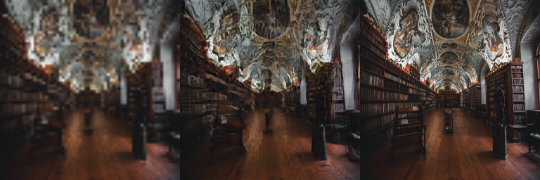

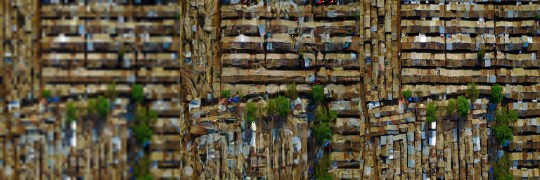

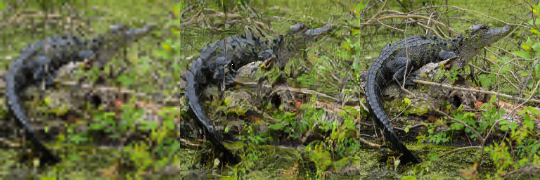

In [ ]:
for i in range(3):
  lr, hr = next(iter(val_ds))
  val_steps(lr, hr) 

### Calculate FID and Inception Scores

FID and Inception Scores are two common metrices used to evaluate the performance of a GAN model and PSNR value is used to quantify the similarity between two images and is used for benchmarking super resolution models. 


In [ ]:
def get_fid_score(real_image, gen_image):
  size = tfgan.eval.INCEPTION_DEFAULT_IMAGE_SIZE

  resized_real_images = tf.image.resize(real_image, [size, size], method=tf.image.ResizeMethod.BILINEAR)
  resized_generated_images = tf.image.resize(gen_image, [size, size], method=tf.image.ResizeMethod.BILINEAR)
  
  num_inception_images = 8
  num_batches = Params['batch_size'] // num_inception_images
  
  fid = tfgan.eval.frechet_inception_distance(resized_real_images, resized_generated_images, num_batches=num_batches)
  return fid

def get_inception_score(images, num_inception_images = 8):
  size = tfgan.eval.INCEPTION_DEFAULT_IMAGE_SIZE
  resized_images = tf.image.resize(images, [size, size], method=tf.image.ResizeMethod.BILINEAR)

  num_batches = Params['batch_size'] // num_inception_images
  inc_score = tfgan.eval.inception_score(resized_images, num_batches=num_batches)

  return inc_score

In [ ]:
generator = tf.keras.models.load_model(Params['model_dir'] + '/InterpolatedGenerator')

fid_metric = tf.keras.metrics.Mean()
inc_metric = tf.keras.metrics.Mean()
psnr_metric = tf.keras.metrics.Mean()

In [ ]:
count = 0
i = 0
while i < Params['val_steps']: 
  lr, hr = next(val_ds)
  
  gen = generator(lr)
  fid = get_fid_score(hr, gen)
  real_is = get_inception_score(hr)
  gen_is = get_inception_score(gen)

  fid_metric(fid)
  inc_metric(gen_is)
  psnr_metric(tf.reduce_mean(tf.image.psnr(gen, hr, max_val = 256.0)))